In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern

In [9]:
filename = "D:\IITG Onedrive\OneDrive - Indian Institute of Technology Guwahati\IITG\Beyond Course\TIM\Datasets\WK100_1.txt"
weights = []
#i = 0
with open(filename, 'r') as file:
    for line in file:
        words = line.split()
        if len(words) == 3:
            weight = int(words[2])
            weights.append(weight)

density = 20

for i in range(len(weights)):
    if np.random.randint(0,100) >= density:
        weights[i] = 0
    else:
        weights[i] = -abs(weights[i])

In [10]:
def coupling_matrix(N, weights):
    J = np.zeros((N, N))
    k = 0
    for i in range(N-1):
        for j in range(N-1, i, -1):
            J[i,j] = weights[k]
            k = k + 1
    J = J + np.transpose(J) # ensuring that J is symmetric
    return J

def definitions(N, Tmax):  
    # N is the total number of spins
    # Tmax is the total number of evolutions

    x = np.zeros((N, Tmax))   #the value of the voltages
    f = np.zeros((N, Tmax))   #the function f
    g = np.random.normal(0, 0.005, size=(N, Tmax)) #gaussian noise

    # all the above three arrays have been defined such that 
    # the second dimension corresponds to different number of evolutions
    # the first dimension includes different spins 

    h = 0
    # h is the uniform external magnetic field to be used in the Hamiltonian

    J = coupling_matrix(N, h)

    # ensuring that J is symmetric

    # the coupling matrix J is now a tridiagonal matrix after assuming that only 
    # the nearest neighbour interactions are significant

    return x, f, g, J

def voltage(alpha, beta, N, Tmax, x, f, g, J):  
    for k in range(Tmax-1):
        for n in range(N):
            sum1 = 0
            if beta != 0:
                for j in range(N):
                    sum1 += J[j, n]*x[j, k]
            f[n, k] = alpha*x[n, k] + beta*sum1                              #equation 3.2 in the paper with beta=0
            x[n, k+1] = (np.cos(f[n, k] + g[n, k] - np.pi/4))**2 - 0.5       #equation 3.1 in the paper
    return x

def fun(alpha, beta):
    N = 100
    Tmax = 30
    flag = 0
    y = np.zeros(1)
    
    for k in range(5):
        x, f, g, J = definitions(N, Tmax)
        x = voltage(alpha, beta, N, Tmax, x, f, g, J)
        if x[0,-1] > 0:
            flag = 1
        
        for i in range(1,N,1):
            if J[i-1, i] < 0:
                if x[i, -1] > 0:
                    if flag == 1:
                        y[0] += 1
                    flag = 1
                else:
                    if flag == -1:
                        y[0] += 1
                    flag = -1
            if J[i-1, i] > 0:
                if x[i, -1] > 0:
                    if flag == -1:
                        y[0] += 1
                    flag = 1
                else:
                    if flag == 1:
                        y[0] += 1
                    flag = -1
    y /= 0.05*N
    y = 100 - y
    return y

In [3]:
from scipy.stats import norm

def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    '''
    Computes the EI at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.
    
    Args:
        X: Points at which EI shall be computed (m x d).
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.
        xi: Exploitation-exploration trade-off parameter.
    
    Returns:
        Expected improvements at points X.
    '''
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)

    sigma = sigma.reshape(-1, 1)
    
    # Needed for noise-based model,
    # otherwise use np.max(Y_sample).
    # See also section 2.4 in [1]
    mu_sample_opt = np.max(mu_sample)

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei

from scipy.optimize import minimize

def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
    '''
    Proposes the next sampling point by optimizing the acquisition function.
    
    Args:
        acquisition: Acquisition function.
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.

    Returns:
        Location of the acquisition function maximum.
    '''
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None
    
    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr)
    
    # Find the best optimum by starting from n_restart different random points.
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')        
        if res.fun < min_val:
            min_val = res.fun
            min_x = res.x           
            
    return min_x.reshape(-1, 1)

def plot_approximation(gpr, X, X_sample, Y_sample, X_next=None, show_legend=False):
    mu, std = gpr.predict(X, return_std=True)
    plt.fill_between(X.ravel(), 
                     mu.ravel() + 1.5 * std, 
                     mu.ravel() - 1.5 * std, 
                     alpha=0.1) 
    #plt.plot(X, Y, 'y--', lw=1, label='Objective')
    plt.plot(X, mu, 'b-', lw=1, label='Surrogate function')
    plt.plot(X_sample, Y_sample, 'kx', mew=3, label='samples')
    if X_next:
        plt.axvline(x=X_next, ls='--', c='k', lw=1)
    if show_legend:
        plt.legend()

def plot_acquisition(X, Y, X_next, show_legend=False):
    plt.plot(X, Y, 'r-', lw=1, label='Acquisition function')
    plt.axvline(x=X_next, ls='--', c='k', lw=1, label='Next sampling location')
    if show_legend:
        plt.legend()

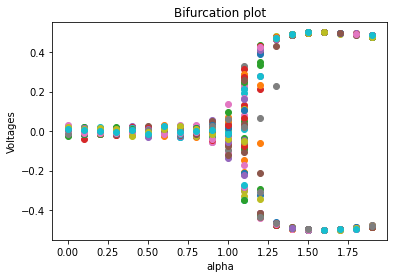

In [42]:
N_bif = 100
Tmax_bif = 30
alpha_bif = np.arange(0, 2, 0.1)
x_bif = np.zeros((len(alpha_bif), N_bif, Tmax_bif))
f_bif = np.zeros((len(alpha_bif), N_bif, Tmax_bif))
g_bif = np.random.normal(0, 0.01, size=(len(alpha_bif), N_bif, Tmax_bif))

def bif_plot(alpha_bif, beta_bif, x_bif, f_bif, g_bif, N_bif, Tmax_bif, J):
    for i in range(len(alpha_bif)):
        for n in range(N_bif):
            for k in range(Tmax_bif-1):
                sum1 = 0
                if beta_bif[i] != 0:
                    for j in range(N_bif):
                        sum1 += J[j, n]*x_bif[i, j, k]
                f_bif[i, n, k] = alpha_bif[i]*x_bif[i, n, k] + beta_bif[i]*sum1
                x_bif[i, n, k+1] = (np.cos(f_bif[i, n, k] + g_bif[i, n, k] - np.pi/4))**2 - 0.5
    return x_bif


x_bif = bif_plot(0.9*np.ones(len(alpha_bif)), alpha_bif, x_bif, f_bif, g_bif, N_bif,
                 Tmax_bif, coupling_matrix(N_bif, weights))

x_bif = bif_plot((alpha_bif), np.zeros(len(alpha_bif)), x_bif, f_bif, g_bif, N_bif,
                 Tmax_bif, coupling_matrix(N_bif, weights))


plt.title("Bifurcation plot")
plt.xlabel("alpha")
plt.ylabel("Voltages")
for i in range(60):
    plt.scatter(alpha_bif, x_bif[:, i, -1])


#for i in range(0,70,5):
 #   beta_bif = 0.01*i*np.ones(len(alpha_bif))
  #  x_bif = bif_plot(alpha_bif, beta_bif, x_bif, f_bif, g_bif, N_bif, Tmax_bif, 
   #                  len(alpha_bif), coupling_matrix(N_bif, 0))
    #plt.title("Bifurcation Plot. beta={}".format(beta_bif[0]))
#    plt.xlabel("alpha")
 #   plt.ylabel("Voltages")
  #  for j in range(N_bif):
   #     plt.scatter(alpha_bif, x_bif[:, j, -1])
    #plt.show()

9.425872894386345e-05

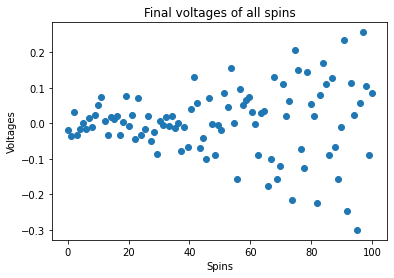

In [40]:
x_bif = np.zeros((len(alpha_bif), N_bif, Tmax_bif))
f_bif = np.zeros((len(alpha_bif), N_bif, Tmax_bif))
g_bif = np.random.normal(0, 0.01, size=(len(alpha_bif), N_bif, Tmax_bif))

y_bif = bif_plot(0.9*np.ones(len(alpha_bif)), 0.1*np.ones(len(alpha_bif)), x_bif, f_bif, g_bif, N_bif,
                 Tmax_bif, coupling_matrix(N_bif, weights))
plt.title("Final voltages of all spins")
plt.ylabel("Voltages")
plt.xlabel("Spins")
plt.scatter(np.linspace(0,N_bif,N_bif), (y_bif[1,:,-1]))
min(abs(y_bif[1,:,-1]))

In [173]:
sum((np.sign(x_bif[-1, :, -1])))

-6.0

In [4]:
noise = 0.2
bounds = np.array([[1e-10, 2.0]])

In [5]:
%matplotlib inline
optimal_values = [[], []]

In [6]:
X = np.arange(0,2.1,0.1).reshape(-1,1) # beta values
Z = np.linspace(1,3,21) # alpha values    
Y = np.zeros(21).reshape(-1,1)
X_init = np.array([[0.4], [1.8]])
Y_init = np.zeros(2).reshape(-1, 1)

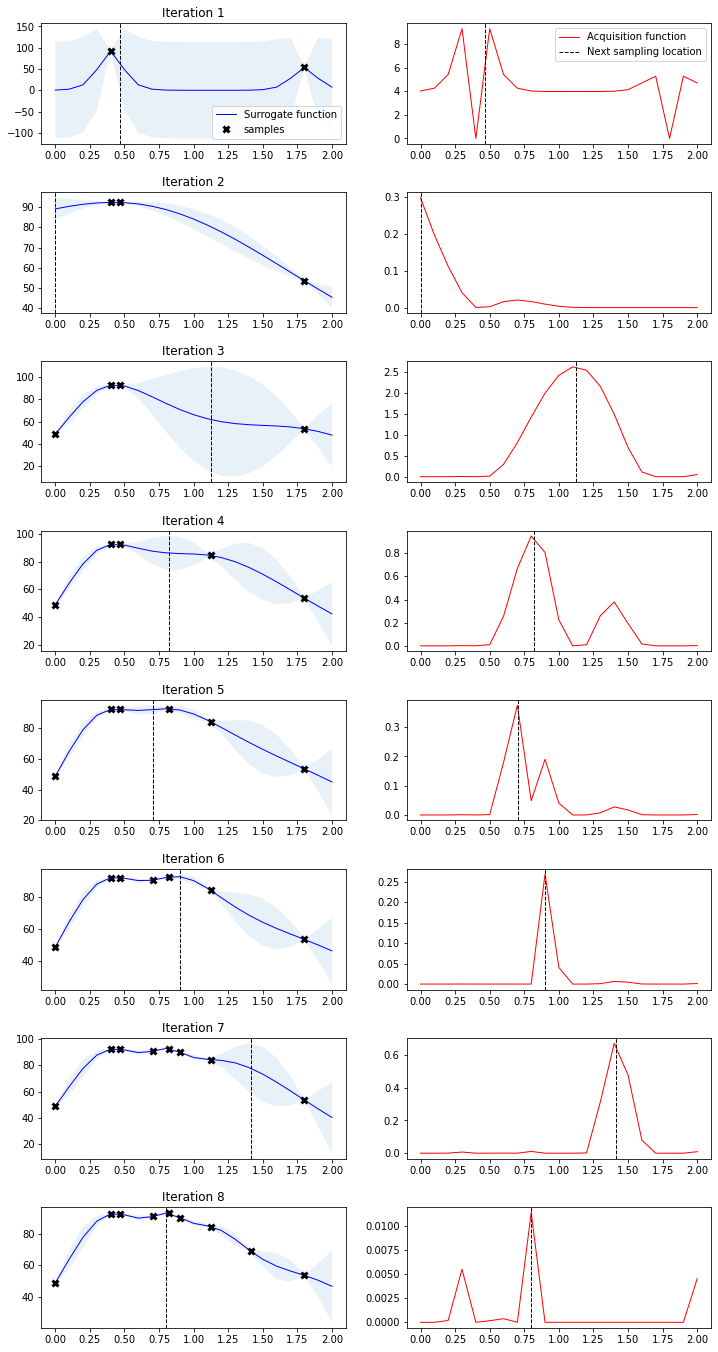

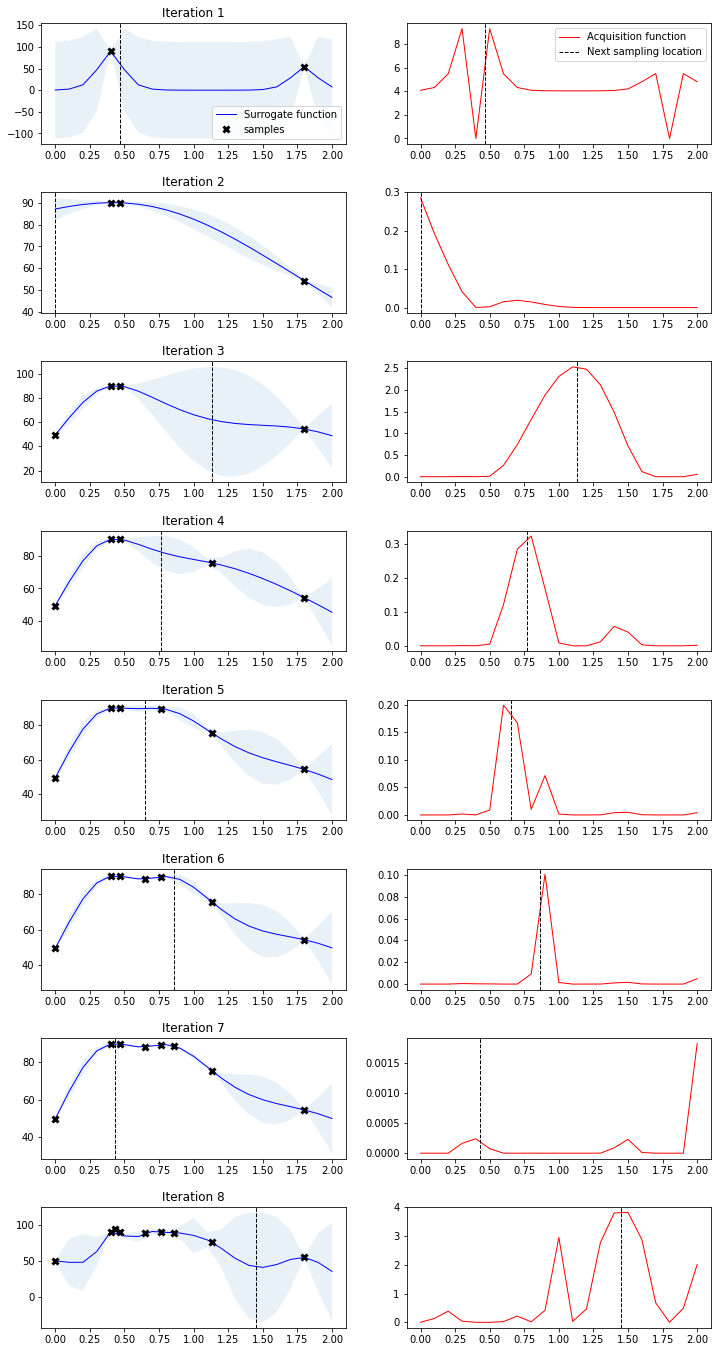

In [31]:
for z_index in range(2):
    n52 = ConstantKernel(1.0) * Matern(length_scale=0.1, length_scale_bounds=(1e-150, 10), nu=2.5)
    gpr = GaussianProcessRegressor(kernel=n52, alpha=noise**2)

    Y_init[0] = fun(Z[z_index], X_init[0])
    Y_init[1] = fun(Z[z_index], X_init[1])

    # Initialize samples
    X_sample = X_init
    Y_sample = Y_init

    # Number of iterations
    n_iter = 8

    plt.figure(figsize=(12, n_iter * 3))
    plt.subplots_adjust(hspace=0.4)

    for i in range(n_iter):
        # Update Gaussian process with existing samples
        gpr.fit(X_sample, Y_sample)

        # Obtain next sampling point from the acquisition function (expected_improvement)
        X_next = propose_location(expected_improvement, X_sample, Y_sample, gpr, bounds)

        # Obtain next noisy sample from the objective function
        Y_next = fun(Z[z_index], X_next)

        # Plot samples, surrogate function, noise-free objective and next sampling location
        plt.subplot(n_iter, 2, 2 * i + 1)
        plot_approximation(gpr, X, X_sample, Y_sample, X_next, show_legend=i==0)
        plt.title(f'Iteration {i+1}')

        plt.subplot(n_iter, 2, 2 * i + 2)
        plot_acquisition(X, expected_improvement(X, X_sample, Y_sample, gpr, 0.5), X_next, show_legend=i==0)

        # Add sample to previous samples
        X_sample = np.vstack((X_sample, X_next))
        Y_sample = np.vstack((Y_sample, Y_next))
    
    optimal_values[0].append(X_sample[np.argmax(Y_sample)])
    optimal_values[1].append(np.max(Y_sample))

In [32]:
optimal_values

[[array([0.82216323]), array([0.43230902])], [92.8, 93.6]]